In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Python reference 

In [2]:
ff = np.loadtxt('../../../forcefields/complexes08_lambda0.159_epsilon-2.27/membrane', usecols=list(range(1, 9)))
ff = ff[:-1] # remove MMM

In [3]:
_database = [['ALA', 'CHARGED', 0],
             ['ILE', 'CHARGED', 8],
             ['VAL', 'CHARGED', 16],
             ['LEU', 'CHARGED', 9],
             ['ARG', 'HYDROPHOBIC', 1],
             ['ASP', 'HYDROPHOBIC', 3],
             ['GLU', 'HYDROPHOBIC', 5],
             ['LYS', 'HYDROPHOBIC', 10],
             ['ASN', 'POLAR', 2],
             ['GLN', 'POLAR', 4],
             ['GLY', 'POLAR', 6],
             ['MET', 'POLAR', 11],
             ['PRO', 'POLAR', 13],
             ['HIS', 'AROMATIC', 7],
             ['PHE', 'AROMATIC', 12],
             ['TRP', 'AROMATIC', 14],
             ['TYR', 'AROMATIC', 15],
             ['CYS', 'NONE', 17],
             ['SER', 'NONE', 18],
             ['THR', 'NONE', 19]
            ]

database = pd.DataFrame(_database, columns=['name', 'type', 'idx'])
groups = ('CHARGED', 'HYDROPHOBIC', 'POLAR', 'AROMATIC')

In [4]:
def f(x, a):
    return a[0] + a[1] * np.exp(-a[2] * (x - a[3])**2) + a[4] * np.exp(-a[5] * (x - a[6])**2)

def ref(x, ff):
    return -np.log(np.sum([(f(x, a)) for a in ff], axis=0))

def pot_mean_force(x, ff, i):
    return -np.log(f(x, ff[i])) - ref(x, ff) - ff[i, -1]

def complexes_force(x, ff, i, z0=20):
    return pot_mean_force(x, ff, i) + 0.05*(z0/np.abs(x))

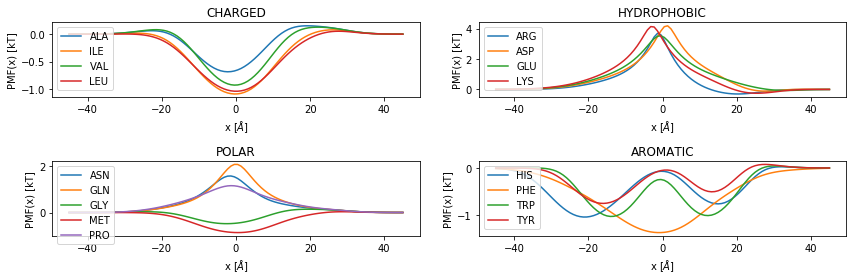

In [5]:
# Ulmschneider FF
fig, axes = plt.subplots(2, 2, figsize=plt.figaspect(1/3))
x = np.linspace(-45, 45, 100)
gb = database.groupby('type')

for ax, group in zip(axes.ravel(), groups):
    g = gb.get_group(group)
    for i, name in zip(g.idx, g.name):
        ax.plot(x, pot_mean_force(x, ff, i), label=name)
    ax.set(title=group, xlabel=r'x [$\AA$]', ylabel='PMF(x) [kT]')
    ax.legend(loc='upper left')

fig.tight_layout()

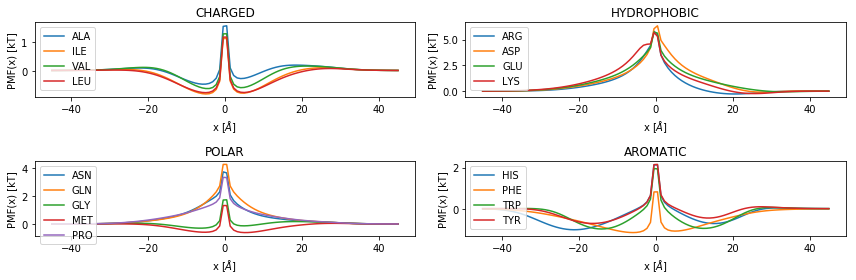

In [6]:
# complexes FF z0=20
fig, axes = plt.subplots(2, 2, figsize=plt.figaspect(1/3))
x = np.linspace(-45, 45, 100)
gb = database.groupby('type')

for ax, group in zip(axes.ravel(), groups):
    g = gb.get_group(group)
    for i, name in zip(g.idx, g.name):
        ax.plot(x, complexes_force(x, ff, i), label=name)
    ax.set(title=group, xlabel=r'x [$\AA$]', ylabel='PMF(x) [kT]')
    ax.legend(loc='upper left')

fig.tight_layout()

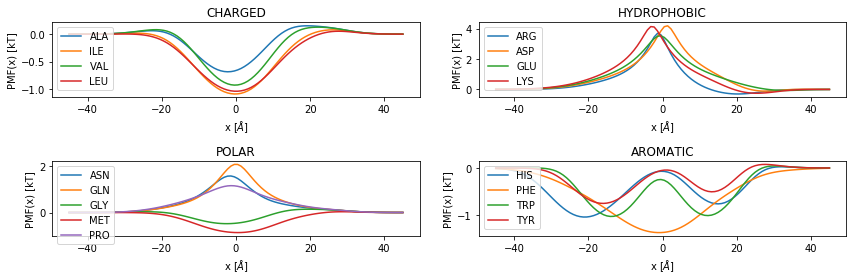

In [7]:
# complexes FF z0=0
fig, axes = plt.subplots(2, 2, figsize=plt.figaspect(1/3))
x = np.linspace(-45, 45, 100)
gb = database.groupby('type')

for ax, group in zip(axes.ravel(), groups):
    g = gb.get_group(group)
    for i, name in zip(g.idx, g.name):
        ax.plot(x, complexes_force(x, ff, i, z0=0), label=name)
    ax.set(title=group, xlabel=r'x [$\AA$]', ylabel='PMF(x) [kT]')
    ax.legend(loc='upper left')

fig.tight_layout()

# complexes++ Test 

In [8]:
import MDAnalysis as mda
from MDAnalysisTests.datafiles import PDB, XTC
import datreant.core as dtr
import pandas as pd

/home/max/anaconda3/lib/python3.6/site-packages/MDAnalysisTests/__init__.py:128: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/max/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/max/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/max/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/max/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/max/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_

In [9]:
# generate MDA test trajectory
u = mda.Universe(PDB, XTC)
u.dimensions = [500, 500, 500, 90, 90, 90]
atom = u.select_atoms('bynum 1-2')
atom.positions[0] = [250, 250, 250]

# membrane is centered in box. So we have the same range as above now.
xs = np.linspace(200, 300, 1000)
with mda.Writer('test-energy.trr', n_atoms=2) as W:
    for x in xs:
        atom.positions = [[250., 250., x], [250, 250, x]]
        W.write(atom)

/home/max/anaconda3/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:195: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [34]:
cplx_template = """box: [500, 500, 500]
definitions:
  domains:
    flat:
      defaults: 
        ePSI0: -30 
        type: flat
        z0: {z0}
      move: membrane
    rigid:
      defaults: 
        rotation: 0.2
        translation: 5
      move: rigid
  pair-interaction:
  - domain-type-pair: [default, default]
    function: LJH
  - domain-type-pair: [rigid, flat]
    function: Membrane
topologies:
- connections: []
  domains:
    0:
      chain-ids: [Z 1]
      name: cellsurface
      nbeads: 1
      type: flat
      zaxis: 250
  name: membrane
  ndomains: 1
- connections: []
  domains:
    1:
      beads: [{residue},]
      chain-ids: [A 1,]
      charges: [0,]
      coordinates:
      - [250, 250, 250]
      mc-moves: {{}}
      meta-data: {{}}
      name: 1rigid1
      nbeads: 1
      type: rigid
  name: aminoacid
  ndomains: 1
{other}
"""


In [35]:
from pycomplexes import forcefield
import yaml

In [41]:
kimhummer = forcefield.read_forcefield(forcefield.get_forcefield_file('KimHummer'))
kimhummer['alpha'] = 1
kimhummer['debye-length'] = 10
kimhummer['dielectric-constant'] = 80
kimhummer = dict(forcefield=kimhummer)
kimhummer = yaml.dump(kimhummer)

In [42]:
config_template = """
structure: {residue}.cplx
montecarlo:
    algorithm: nvt
    algorithm-params:
        accept-func: metropolis
        temperatur: 100
    seed: 3333
    initial-position:
        strategy: none
    short-range-cutoff:
        enable: False
output:
    log: log.log
    file: ../test-energy.trr
    freq: 5
    nstructures: 50
    stat-file: energy.stat
    restart-freq: -1
"""

In [43]:
amino_acids = np.loadtxt('../../../forcefields/complexes08_lambda0.159_epsilon-2.27/membrane', usecols=0, dtype=object)
amino_acids = amino_acids[:-1] # remove MMM membrane entry

In [44]:
z0 = 0

for a in amino_acids:
    t = dtr.Treant(f'Residue-{a}')
    t.categories['residue'] = a
    with open(t['config.yaml'].abspath, 'w') as fh:
        fh.write(config_template.format(residue=a))
    with open(t[f'{a}.cplx'].abspath, 'w') as fh:
        fh.write(cplx_template.format(residue=a, z0=z0, other=kimhummer))

In [46]:
%%bash  --err /dev/null --out /dev/null
for folder in Residue-*
do
   cd $folder
   complexes++ -c config.yaml --rerun=True --nb-threads=1
   cd ..
done

In [47]:
bundle = dtr.discover('.')

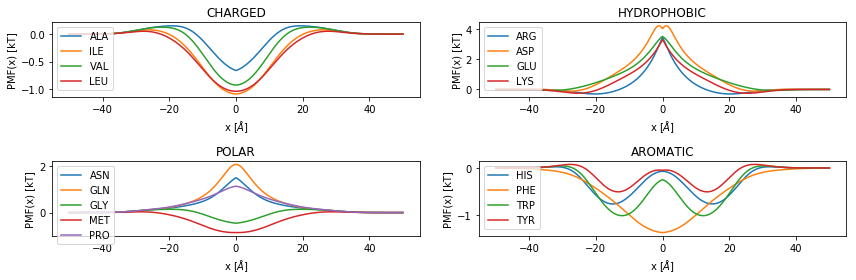

In [48]:
# complexes FF z0=0 program
fig, axes = plt.subplots(2, 2, figsize=plt.figaspect(1/3))
x = np.linspace(-45, 45, 100)
gb = database.groupby('type')
bundle_gb = bundle.categories.groupby('residue')

for ax, group in zip(axes.ravel(), groups):
    g = gb.get_group(group)
    for i, name in zip(g.idx, g.name):
        t = bundle_gb[name][0]
        df = pd.read_csv(t['energy.stat'].abspath)
        ax.plot(xs - 250, df.energy, label=name)
    ax.set(title=group, xlabel=r'x [$\AA$]', ylabel='PMF(x) [kT]')
    ax.legend(loc='upper left')

fig.tight_layout()

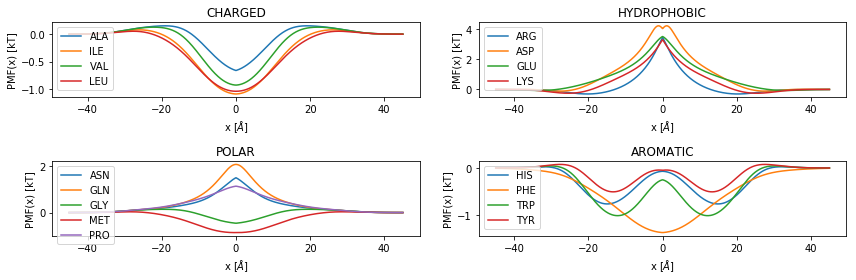

In [49]:
# Ulmschneider FF using abs distance 
fig, axes = plt.subplots(2, 2, figsize=plt.figaspect(1/3))
x = np.linspace(-45, 45, 1000)
gb = database.groupby('type')

for ax, group in zip(axes.ravel(), groups):
    g = gb.get_group(group)
    for i, name in zip(g.idx, g.name):
        ax.plot(x, pot_mean_force(np.abs(x), ff, i), label=name)
    ax.set(title=group, xlabel=r'x [$\AA$]', ylabel='PMF(x) [kT]')
    ax.legend(loc='upper left')

fig.tight_layout()

In [50]:
# Ulmschneider FF
x = np.linspace(-50, 50, 1000)
bundle_gb = bundle.categories.groupby('residue')

for i, row in database.iterrows():
    name = row['name']
    python = complexes_force(np.abs(x), ff, row['idx'], z0=0)
    if name in ('SER', 'CYS', 'THR'):
        python = np.zeros(python.shape)
    cpp = pd.read_csv(bundle_gb[name][0]['energy.stat'].abspath).energy
    try:
        np.testing.assert_almost_equal(cpp, python, decimal=5)
    except:
        print("failed for ", name)
    print(name, np.sum(np.abs(cpp - python)))


ALA 0.00021852341067537796
ILE 0.0003775604245034482
VAL 0.0002292787917127304
LEU 0.00031944129831943904
ARG 0.0007144848712115361
ASP 0.0010850219051914032
GLU 0.0008978710581544414
LYS 0.0009105512950805086
ASN 0.00046115249761253076
GLN 0.0006207708208909414
GLY 0.00017702479365811063
MET 0.0001789323189636763
PRO 0.0003323079136465306
HIS 0.0002679118170822337
PHE 0.0006675089272331798
TRP 0.00040713112183582705
TYR 0.00019300644651562397
CYS 0.0
SER 0.0
THR 0.0


/home/max/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log


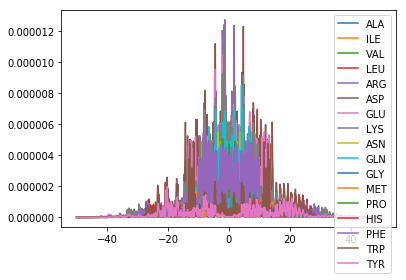

In [51]:
# Ulmschneider FF
fig, ax = plt.subplots()
x = np.linspace(-50, 50, 1000)
bundle_gb = bundle.categories.groupby('residue')

for i, row in database.iterrows():
    name = row['name']
    if name in ('CYS', 'SER', 'THR'):
        continue
    python = complexes_force(np.abs(x), ff, row['idx'], z0=0)
    cpp = pd.read_csv(bundle_gb[name][0]['energy.stat'].abspath).energy
    #print(name, np.allclose(cpp, python), np.sum(np.abs(cpp - python)))
    ax.plot(x, np.abs(cpp - python), label=name)
ax.legend()

# Store reference results 

In [52]:
for i, row in database.iterrows():
    name = row['name']
    python = complexes_force(np.abs(x), ff, row['idx'], z0=0)
    if name in ('SER', 'CYS', 'THR'):
        python = np.zeros(python.shape)
    np.savez(f'Residue-{name}/ref.npz', python)

/home/max/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log


In [53]:
from glob import glob

In [54]:
folders = glob('Residue-*')

In [55]:
folders[0].split('-')[-1]

'GLY'

In [56]:
import os

In [57]:
res = True
for f in folders:
    cpp = pd.read_csv(os.path.join(f, 'energy.stat')).energy
    ref = np.load(os.path.join(f, 'ref.npz'))['arr_0']
    np.testing.assert_almost_equal(ref, cpp, decimal=3)

    try:
        np.testing.assert_almost_equal(ref, cpp, decimal=3)
    except:
        print(f)
        res = False
print(res)

True


In [58]:
!ls -lh

total 708K
-rw-r--r-- 1 max max 5.4K May 12 14:44 CMakeLists.txt
-rw-r--r-- 1 max max 465K Jun 30 12:48 generate-reference-energies.ipynb
drwxr-xr-x 2 max max 4.0K Jun 30 12:50 Residue-ALA
drwxr-xr-x 2 max max 4.0K Jun 30 12:50 Residue-ARG
drwxr-xr-x 2 max max 4.0K Jun 30 12:50 Residue-ASN
drwxr-xr-x 2 max max 4.0K Jun 30 12:50 Residue-ASP
drwxr-xr-x 2 max max 4.0K Jun 30 12:50 Residue-CYS
drwxr-xr-x 2 max max 4.0K Jun 30 12:50 Residue-GLN
drwxr-xr-x 3 max max 4.0K Jun 30 12:50 Residue-GLU
drwxr-xr-x 2 max max 4.0K Jun 30 12:50 Residue-GLY
drwxr-xr-x 2 max max 4.0K Jun 30 12:50 Residue-HIS
drwxr-xr-x 2 max max 4.0K Jun 30 12:50 Residue-ILE
drwxr-xr-x 2 max max 4.0K Jun 30 12:50 Residue-LEU
drwxr-xr-x 2 max max 4.0K Jun 30 12:50 Residue-LYS
drwxr-xr-x 2 max max 4.0K Jun 30 12:50 Residue-MET
drwxr-xr-x 2 max max 4.0K Jun 30 12:50 Residue-PHE
drwxr-xr-x 2 max max 4.0K Jun 30 12:50 Residue-PRO
drwxr-xr-x 2 max max 4.0K Jun 30 12:50 Residue-SER
drwxr-xr-x 2 max max 4.0K Jun 30 12:50 Residue

In [59]:
for f in folders:
    name=f.split('-')[-1]
    print(f'file(COPY "{f}/ref.npz" DESTINATION ${{CMAKE_CURRENT_BINARY_DIR}}/{f})')
    print(f'file(COPY "{f}/config.yaml" DESTINATION ${{CMAKE_CURRENT_BINARY_DIR}}/{f})')
    print(f'file(COPY "{f}/{name}.cplx" DESTINATION ${{CMAKE_CURRENT_BINARY_DIR}}/{f})')
    print()

file(COPY "Residue-GLY/ref.npz" DESTINATION ${CMAKE_CURRENT_BINARY_DIR}/Residue-GLY)
file(COPY "Residue-GLY/config.yaml" DESTINATION ${CMAKE_CURRENT_BINARY_DIR}/Residue-GLY)
file(COPY "Residue-GLY/GLY.cplx" DESTINATION ${CMAKE_CURRENT_BINARY_DIR}/Residue-GLY)

file(COPY "Residue-PHE/ref.npz" DESTINATION ${CMAKE_CURRENT_BINARY_DIR}/Residue-PHE)
file(COPY "Residue-PHE/config.yaml" DESTINATION ${CMAKE_CURRENT_BINARY_DIR}/Residue-PHE)
file(COPY "Residue-PHE/PHE.cplx" DESTINATION ${CMAKE_CURRENT_BINARY_DIR}/Residue-PHE)

file(COPY "Residue-CYS/ref.npz" DESTINATION ${CMAKE_CURRENT_BINARY_DIR}/Residue-CYS)
file(COPY "Residue-CYS/config.yaml" DESTINATION ${CMAKE_CURRENT_BINARY_DIR}/Residue-CYS)
file(COPY "Residue-CYS/CYS.cplx" DESTINATION ${CMAKE_CURRENT_BINARY_DIR}/Residue-CYS)

file(COPY "Residue-ASP/ref.npz" DESTINATION ${CMAKE_CURRENT_BINARY_DIR}/Residue-ASP)
file(COPY "Residue-ASP/config.yaml" DESTINATION ${CMAKE_CURRENT_BINARY_DIR}/Residue-ASP)
file(COPY "Residue-ASP/ASP.cplx" DESTINATIO